# Homework 3, Exercise 1
*Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss*

November 22, 2020

## Interpolation

The goal of this exercise is for you to try nearest-neighbor, bilinear and cardinal sine (``sinc``) interpolation of an image by generating and applying interpolation kernels.

For this, you should first downsample an image, and then increase its sampling again by applying each of the interpolation methods.

You need to replace the `??` in the code with the required commands.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import time
%matplotlib notebook

Increase default figure size:

In [2]:

import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['image.cmap'] = "gray"
plt.rcParams['image.interpolation'] = None

Activate pyplot interactive mode:

In [3]:
plt.ion()

a) First, read an image using matplotlib tools and **normalize it** to $[0, 1]$. Use **only one color channel**, and **mirror the image on the x-axis**.

In [4]:
img = plt.imread('tree_new.jpg')[:, :, 0]
img = img / img.max()
img2=img.copy()
img = img[:, ::-1] #reverse order of elements
sh = np.shape(img)
sh
#print(img[:5, :5])
#print(img2[:5, -6:-1])



(630, 630)

<IPython.core.display.Javascript object>


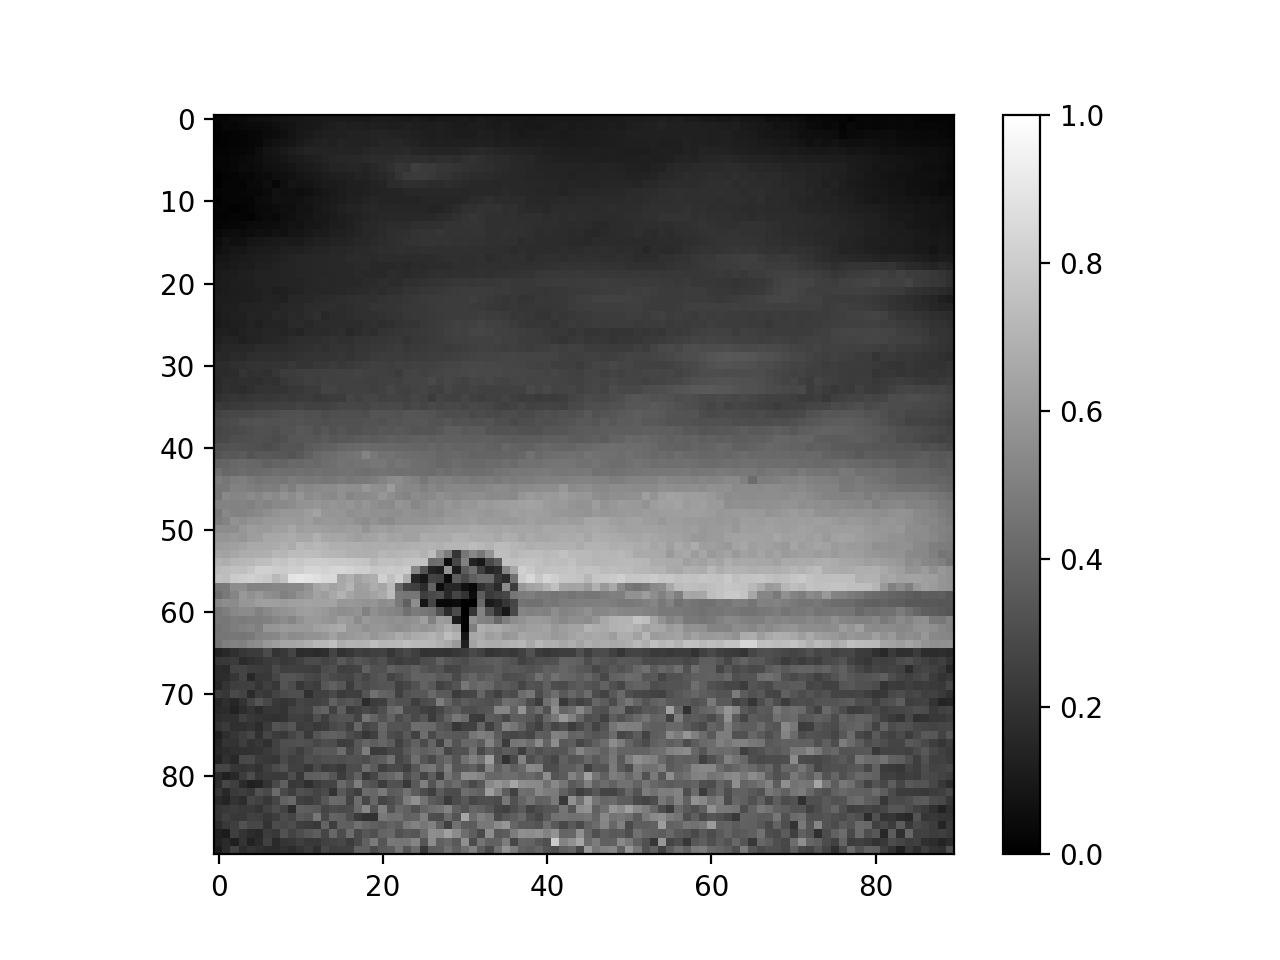

In [5]:
plt.figure()
plt.imshow(img)

#plt.figure()
#plt.imshow(img2)

<IPython.core.display.Javascript object>


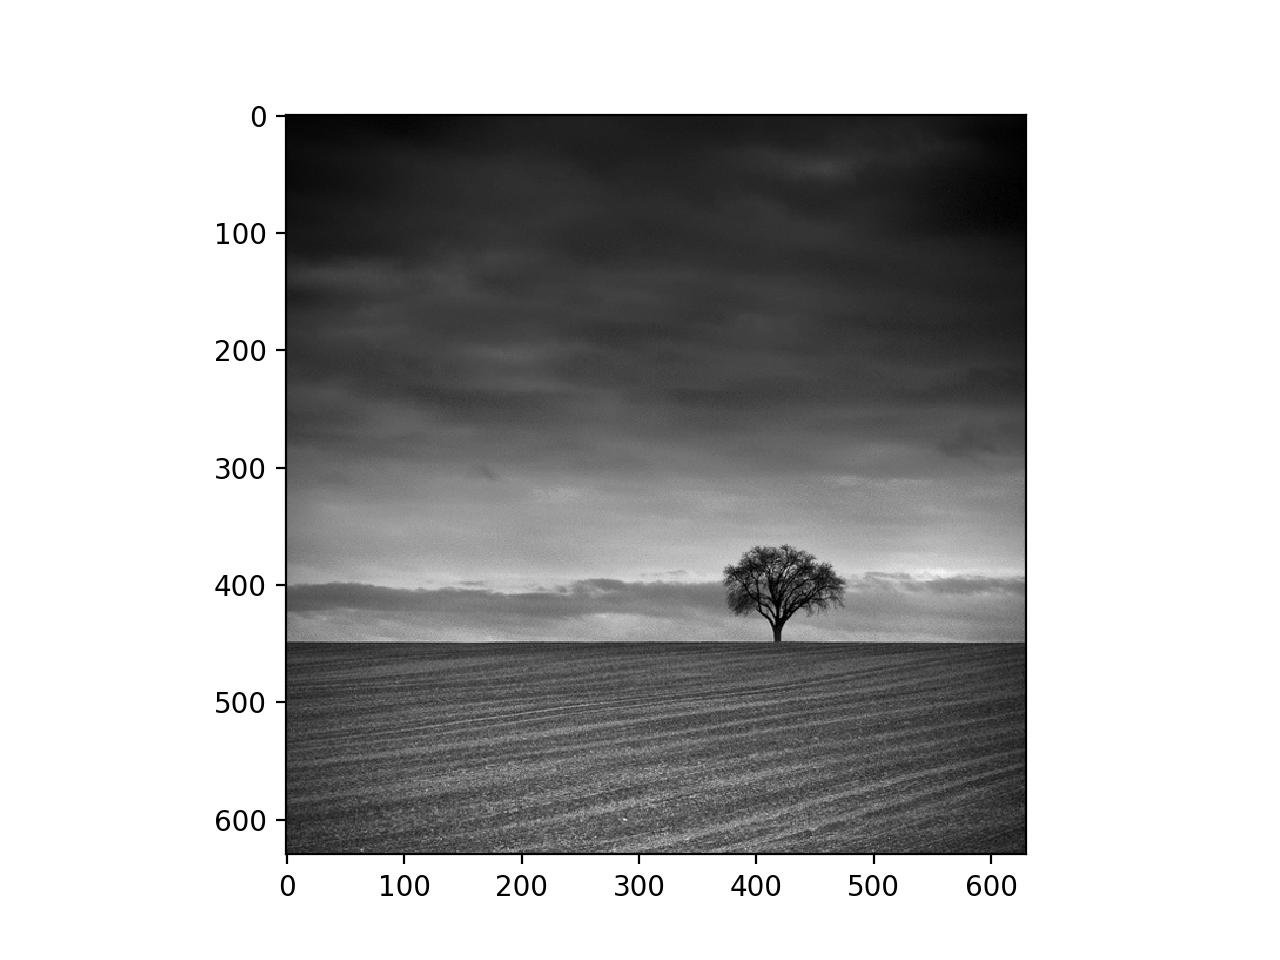

In [6]:
plt.figure()
plt.imshow(img2)

b) Subsample the original image by factor 7 by keeping only every 7-th row and column.

**Hint:** Remember array indexing, `a[start:stop:step]`

In [7]:
scale_factor = 7
img_subsampled = img[::scale_factor, ::scale_factor]

Show the subsampled image:

In [8]:
plt.figure(1)
plt.imshow(img_subsampled, cmap="gray", vmax=1.)
plt.colorbar()

Use python's `assert()` function to ensure the new image width is below  or equal to $\frac{1}{7}$-th of the original image width.

**Remember:** Assert statements can be used to validate the correct functionality of your program: Imagine your downsampling function returns an image with a wrong resolution. It is often better to crash the program than unknowingly continuing the program with a wrong result.

In [9]:
assert img_subsampled.shape[1]<= img.shape[1]//7

**OPTIONAL TASK:** Make a better downsampled version of the image by **binning**: Instead of picking every 7th row and column as we did above, we average patches of $7 \times 7$ pixels into a single pixel. This makes for a less noisy downsampled version of the image.

Instead of doing that with for loops, we can do this by clever resorting of image data:

First, reshape the `2d` array into a `4d` array, where the two new axes contain the values that are to be averaged. Use `np.reshape` for this task.

In [10]:
np.mean?

In [11]:
#90 batches, each of 7x7 dimensions. First over y and then over x
reshaped_image = np.reshape(img, (sh[0] // scale_factor, scale_factor, sh[1] // scale_factor, scale_factor))

Print the shape of the reshaped array. It should be `(90, 7, 90, 7)`:

In [12]:
print("Shape of the reshaped image:",  reshaped_image.shape)

Shape of the reshaped image: (90, 7, 90, 7)


Next, calculate the mean of the array along the axes 1 and 3 (the ones with length 7):

In [13]:
print(len(reshaped_image[0][0]), len(reshaped_image[0]))

90 7


In [14]:
len(img[0])

630

In [15]:
img_binned = np.mean(reshaped_image, (1,3))
img_binned

array([[0.01920768, 0.02689076, 0.03441377, ..., 0.02088836, 0.0180072 ,
        0.01752701],
       [0.01176471, 0.01896759, 0.02456983, ..., 0.02665066, 0.0240096 ,
        0.02232893],
       [0.00720288, 0.01168467, 0.01696679, ..., 0.03169268, 0.03129252,
        0.02857143],
       ...,
       [0.15046018, 0.15990396, 0.16030412, ..., 0.23793517, 0.20904362,
        0.20992397],
       [0.17767107, 0.17438976, 0.16454582, ..., 0.23369348, 0.22232893,
        0.19471789],
       [0.16486595, 0.18207283, 0.18567427, ..., 0.20920368, 0.20840336,
        0.2020008 ]])

Compare the difference to simple subsampling:

<IPython.core.display.Javascript object>


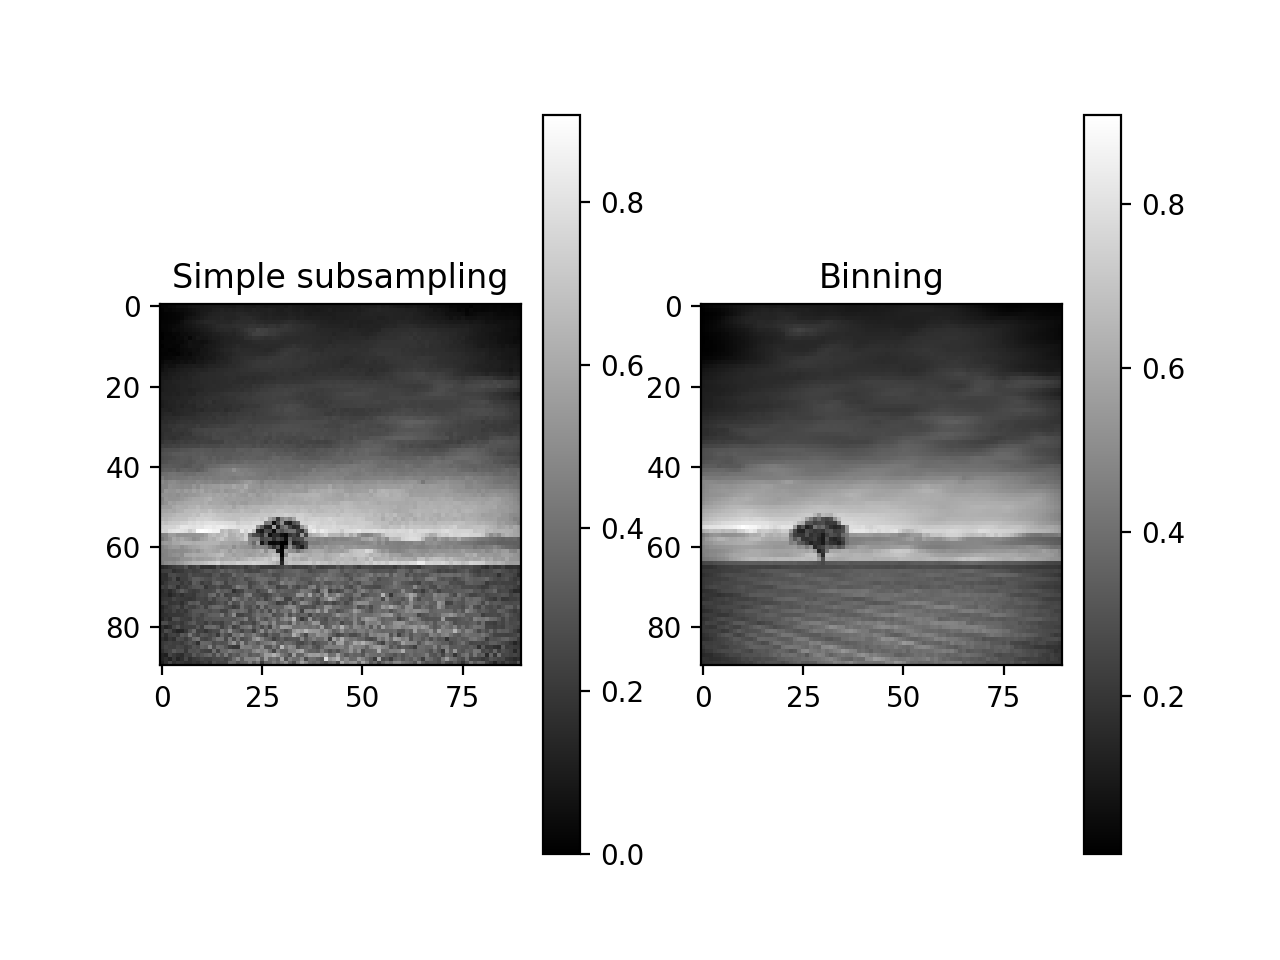

In [16]:
plt.figure()
plt.subplot(121); plt.title('Simple subsampling')
plt.imshow(img_subsampled, cmap='gray'); plt.colorbar()
plt.subplot(122); plt.title('Binning')
plt.imshow(img_binned, cmap='gray'); plt.colorbar()

We overwrite `img_subsampled` with `img_binned` so that we use that for the rest of the exercise

In [17]:
img_subsampled = img_binned

**(OPTIONAL TASK END)**

The following tasks are **NOT** optional.

c) Prepare the subsampled image for interpolation by inserting zeros between all
pixel values in `img_subsampled`. `img_up` should be the same size as the original (`img`).
To fill the upscaled image with a sparse matrix, remember the `array[start:stop:step]` syntax for slicing. 

Generate a matrix with shape `sh`, which contains only zeros:

In [18]:
img_up = np.zeros(sh)
img_up

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Next, fill the pixels of `img_subsampled`. We select every 7th pixel on the x and y axis as a destination. The source is the img_subsampled image. We measure the time of this operation.

In [19]:
np.arange(3, 630, 7)


array([  3,  10,  17,  24,  31,  38,  45,  52,  59,  66,  73,  80,  87,
        94, 101, 108, 115, 122, 129, 136, 143, 150, 157, 164, 171, 178,
       185, 192, 199, 206, 213, 220, 227, 234, 241, 248, 255, 262, 269,
       276, 283, 290, 297, 304, 311, 318, 325, 332, 339, 346, 353, 360,
       367, 374, 381, 388, 395, 402, 409, 416, 423, 430, 437, 444, 451,
       458, 465, 472, 479, 486, 493, 500, 507, 514, 521, 528, 535, 542,
       549, 556, 563, 570, 577, 584, 591, 598, 605, 612, 619, 626])

In [20]:
starttime = time.time()
img_up[scale_factor//2::scale_factor, scale_factor//2::scale_factor] = img_subsampled #90 rows and cols
print("Time: %.2e seconds" % (time.time() - starttime))

Time: 9.55e-04 seconds


Have a look at (a part of) `img_up`: This is the image to which we will apply the different kernels.

In [21]:
img_up

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<IPython.core.display.Javascript object>


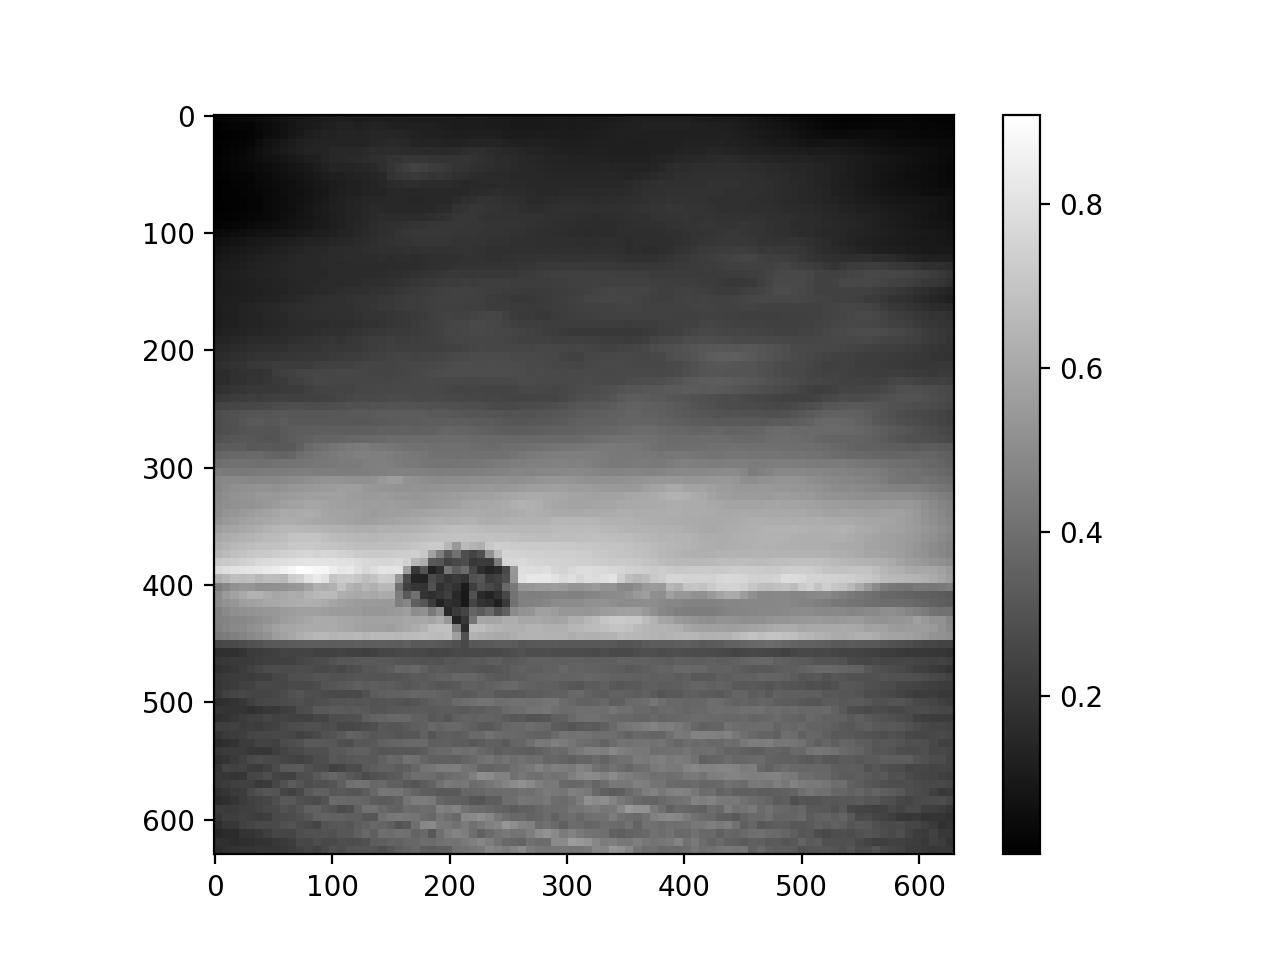

In [22]:
plt.figure()
plt.imshow(img_up, vmin=0)

**d) Implement a for loop doing the same thing** and measure the time again.

To check if the results are equal, compare the sum of both images using `assert`.

In [23]:
img_up_alternative = np.zeros(sh) #630x630
starttime = time.time()

for i in range(img_subsampled.shape[0]): #90 rows
    for j in range(img_subsampled.shape[1]): #90 cols
        i_upsampled = i * scale_factor + scale_factor//2
        j_upsampled = j * scale_factor + scale_factor//2
        img_up_alternative[i_upsampled, j_upsampled] = img_subsampled[i,j]
        
print("Time: %.2e seconds" % (time.time() - starttime))

assert img_up.sum() == img_up_alternative.sum()
assert np.isclose(img_up.sum(), img_up_alternative.sum()) #Returns a boolean array where two arrays are element-wise equal
assert np.allclose(img_up, img_up_alternative)

Time: 1.40e-02 seconds


Notice how this approach is approx. 10 times slower than using NumPy array slicing!

Next, define the interpolation kernel for nearest neighbour interpolation.

**Hint:** The kernel should have a $7 \times 7$ size, as the pixels are seperated by 7 distance units. All kernel values should be 1.

In [24]:
kernel_nearest = np.ones((7,7))
kernel_nearest

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

**e) Perform nearest-neighbor interpolation** using either convolution (easier) or FFT.

You can use `nd.convolve` for the convolution with the parameter `mode='wrap'`.

In [25]:
img_nearest = nd.convolve(img_up, kernel_nearest, mode='wrap') #convolution in space
#Fourier convolution theorem

upscaled_kernel = np.zeros_like(img_up)
kh,kw = kernel_nearest.shape
h,w = img_up.shape
upscaled_kernel [h//2-kh//2:h//2+kh//2+1, w//2-kw//2:w//2+kw//2+1] = kernel_nearest
fourier_kernel= np.fft.ifftshift(upscaled_kernel)
img_nearest_fourier = np.fft.ifft2(np.fft.fft2(img_up)*np.fft.fft2(upscaled_kernel)).real # do I need  to reshape kernel?
img_nearest_fourier2 = np.fft.ifft2(np.fft.fft2(img_up)*np.fft.fft2(fourier_kernel)).real 


<IPython.core.display.Javascript object>


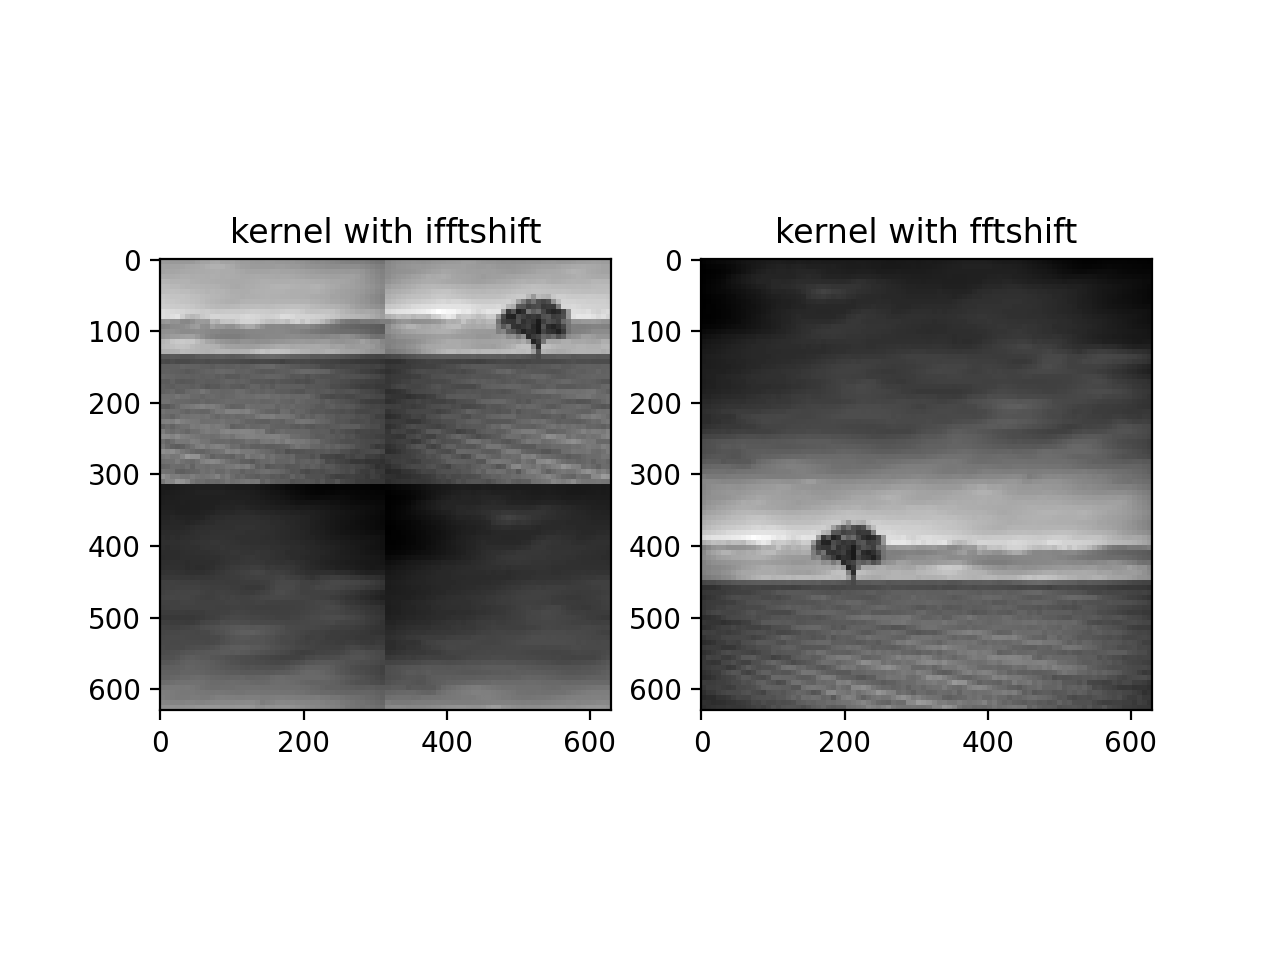

Text(0.5, 1.0, 'kernel with fftshift')

In [47]:
plt.figure()
plt.subplot(121)
plt.imshow(img_nearest_fourier)
plt.title('kernel without ifftshift')

plt.subplot(122)
plt.imshow(img_nearest_fourier2)
plt.title('kernel with fftshift')

In [27]:
plt.figure(4)
plt.imshow(img_nearest, cmap='gray')
plt.colorbar()

In [28]:
plt.figure(5)
plt.subplot(121)
plt.imshow(img_nearest_fourier, cmap='gray')
plt.title('kernel without ifftshift')
plt.subplot(122)
plt.imshow(img_nearest_fourier2, cmap='gray')
plt.title('kernel with ifftshift')

<ipython-input-28-148aefb1b66d>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-28-148aefb1b66d>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


Text(0.5, 1.0, 'kernel with ifftshift')

Make sure 49 pixels in the kernel are set to 1 using the python `assert()` statement:

In [29]:
assert kernel_nearest.sum() == 49
np.all(kernel_nearest)

True

In [30]:
np.isclose?


**f) Perform bilinear interpolation** using convolution and FFT (optional).

Define the interpolation kernel for linear interpolation. This kernel must be larger than $7 \times 7$, because it always uses four adjacent non-zero pixels in ``img_up`` (which are spaced 7 pixels apart)!

**Hint:** the linear kernel can be obtained by a 2D convolution of two rectangular kernels centered in a larger kernel. Make sure to zero-pad the rectangular kernel (see e.g. `np.pad`)! The kernel should fall off to zero towards the edges!

In [48]:
np.pad?

In [32]:
kernel_rect =  np.pad(kernel_nearest, scale_factor// 2 + 1)  #to assure that edges after convolution are zero
kernel_rect
#kernel_linear = nd.convolve(??)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

In [33]:
kernel_rect.shape

(15, 15)

In [34]:
kernel_linear = nd.convolve(kernel_rect, kernel_rect)
kernel_linear


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  6.,  5.,  4.,  3.,  2.,
         1.,  0.],
       [ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 12., 10.,  8.,  6.,  4.,
         2.,  0.],
       [ 0.,  3.,  6.,  9., 12., 15., 18., 21., 18., 15., 12.,  9.,  6.,
         3.,  0.],
       [ 0.,  4.,  8., 12., 16., 20., 24., 28., 24., 20., 16., 12.,  8.,
         4.,  0.],
       [ 0.,  5., 10., 15., 20., 25., 30., 35., 30., 25., 20., 15., 10.,
         5.,  0.],
       [ 0.,  6., 12., 18., 24., 30., 36., 42., 36., 30., 24., 18., 12.,
         6.,  0.],
       [ 0.,  7., 14., 21., 28., 35., 42., 49., 42., 35., 28., 21., 14.,
         7.,  0.],
       [ 0.,  6., 12., 18., 24., 30., 36., 42., 36., 30., 24., 18., 12.,
         6.,  0.],
       [ 0.,  5., 10., 15., 20., 25., 30., 35., 30., 25., 20., 15., 10.,
         5.,  0.],
       [ 0.,  4.,  8., 12., 16., 20., 24., 28., 24., 20., 16., 12.,  8.,
       

<IPython.core.display.Javascript object>


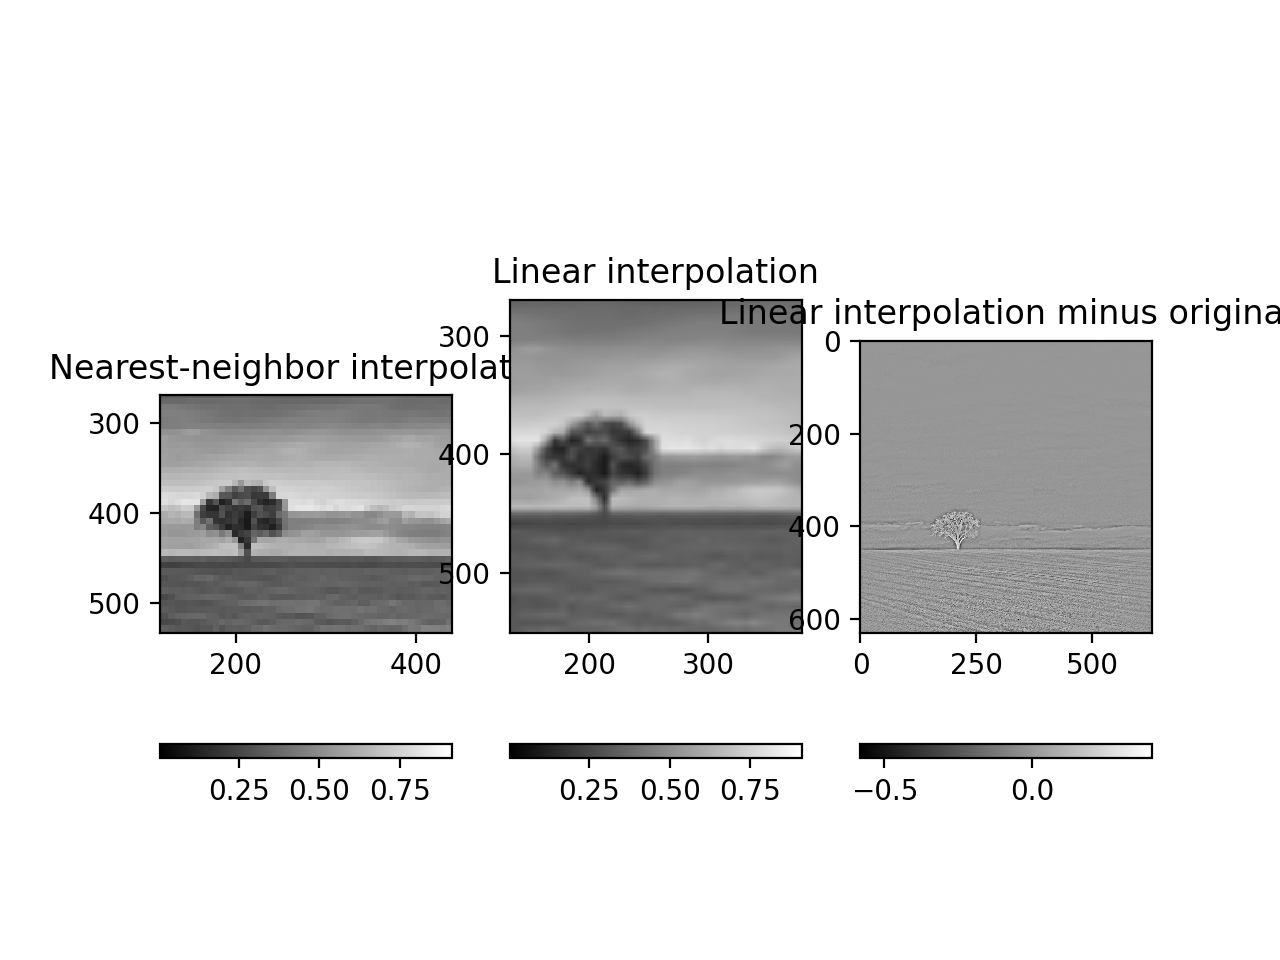

Text(0.5, 1.0, 'upscaled kernel_nearest')

In [35]:
plt.figure()
plt.imshow(kernel_linear, vmin=0)
plt.colorbar()
plt.subplot(121)
plt.imshow(kernel_linear)
plt.title('kernel Linear')
plt.subplot(122)
plt.imshow(upscaled_kernel)
plt.title('upscaled kernel_nearest')

For good measure, normalize the maximum value of the kernel to 1, so that the interpolated pixel values are in the same range as the original.

In [36]:
kernel_linear = kernel_linear / kernel_linear.max()

Convolve `img_up` with the new kernel, use `mode='wrap'` again.

In [37]:
img_linear = nd.convolve(img_up, kernel_linear, mode = 'wrap')

**BONUS:** do the same thing with `np.fft.fft2` and `np.fft.ifft2`. Use only `img_up` and `kernel_nearest` as input data.

Hint: the keyword parameter `s` can be used to set the size of the output array of ``np.fft.fft2`` to match the size of the FFT of `img_up`.

<IPython.core.display.Javascript object>


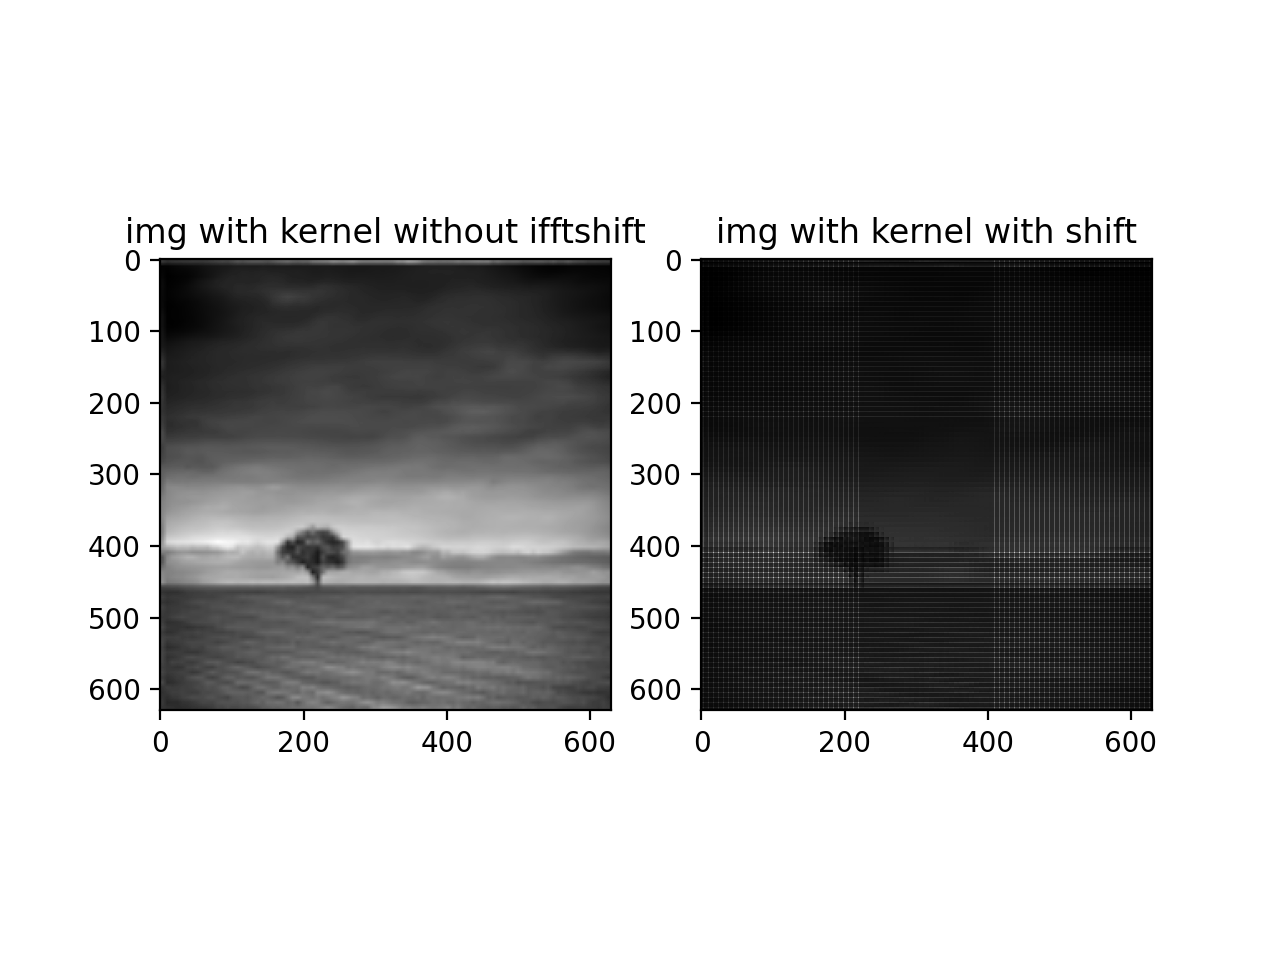

Text(0.5, 1.0, 'img with kernel with shift')

In [49]:
img_fft = np.fft.fft2(img_up)
kernel_linear_fft = np.fft.fft2(kernel_linear, s =img_up.shape)
img_linear_fft = np.fft.ifft2(img_fft * kernel_linear_fft).real

kernel_shifted = np.fft.ifftshift(kernel_linear)
kernel_linear_shift= np.fft.fft2(kernel_shifted, s = img_up.shape)
img_linear_shift = np.fft.ifft2(img_fft*kernel_linear_shift).real #why here we don't have to put the 
                                                                    #center of the kernel at the upper left??

plt.figure()
plt.subplot(121)
plt.imshow(img_linear_fft)
plt.title('img with kernel without ifftshift')
plt.subplot(122)
plt.imshow(img_linear_shift)
plt.title('img with kernel with shift')

Check if the images are normalized correctly and have a look if the filtered
and unfiltered images are correctly aligned.
Also, plot the difference image of the original image and the linear interpolated image:

In [39]:
plt.figure(6)
plt.subplot(131); plt.title('Nearest-neighbor interpolation')
plt.imshow(img_nearest); plt.colorbar(orientation='horizontal')
plt.subplot(132); plt.title('Linear interpolation')
plt.imshow(img_linear); plt.colorbar(orientation='horizontal')
plt.subplot(133); plt.title('Linear interpolation minus original')
plt.imshow(img_linear - img); plt.colorbar(orientation='horizontal')

g) **Perform interpolation with the cardinal sine (sinc) function** using the convolution theorem and FFT.
 
**Hint:** This is easier to do in the frequency (Fourier) domain.

The Fourier transform of `sinc(x)` is given by the "rectangular function" (https://en.wikipedia.org/wiki/Rectangular_function#Fourier_transform_of_the_rectangular_function ).

The Fourier transform of the input image thus gets multiplied with a rectangular function (in 2 dimensions), and the result is transformed back to the spatial domain. The width of the rectangle is given by the width of the subsampled image, `sh`, divided by the subsampling factor.

* Make an image with zeroes the size of `img_up`:

In [40]:
sinc_filter = np.zeros(img_up.shape)
img_up.shape

(630, 630)

* Place a rectangle of ones with the appropriate size in the center of the image
* Apply ``np.fft.fftshift`` so that the center of the image travels to the top left corner

In [41]:
h = img_up.shape[0] // scale_factor
w = img_up.shape[1] // scale_factor
sinc_filter[sh[0]//2-h//2 : sh[0]//2 + h//2, sh[1]//2-w//2 : sh[1]//2 + w//2] = 1
sinc_filter2 = np.fft.fftshift(sinc_filter)
sinc_filter3 = np.fft.ifftshift(sinc_filter)



* Have a look at the filter kernel:

<IPython.core.display.Javascript object>


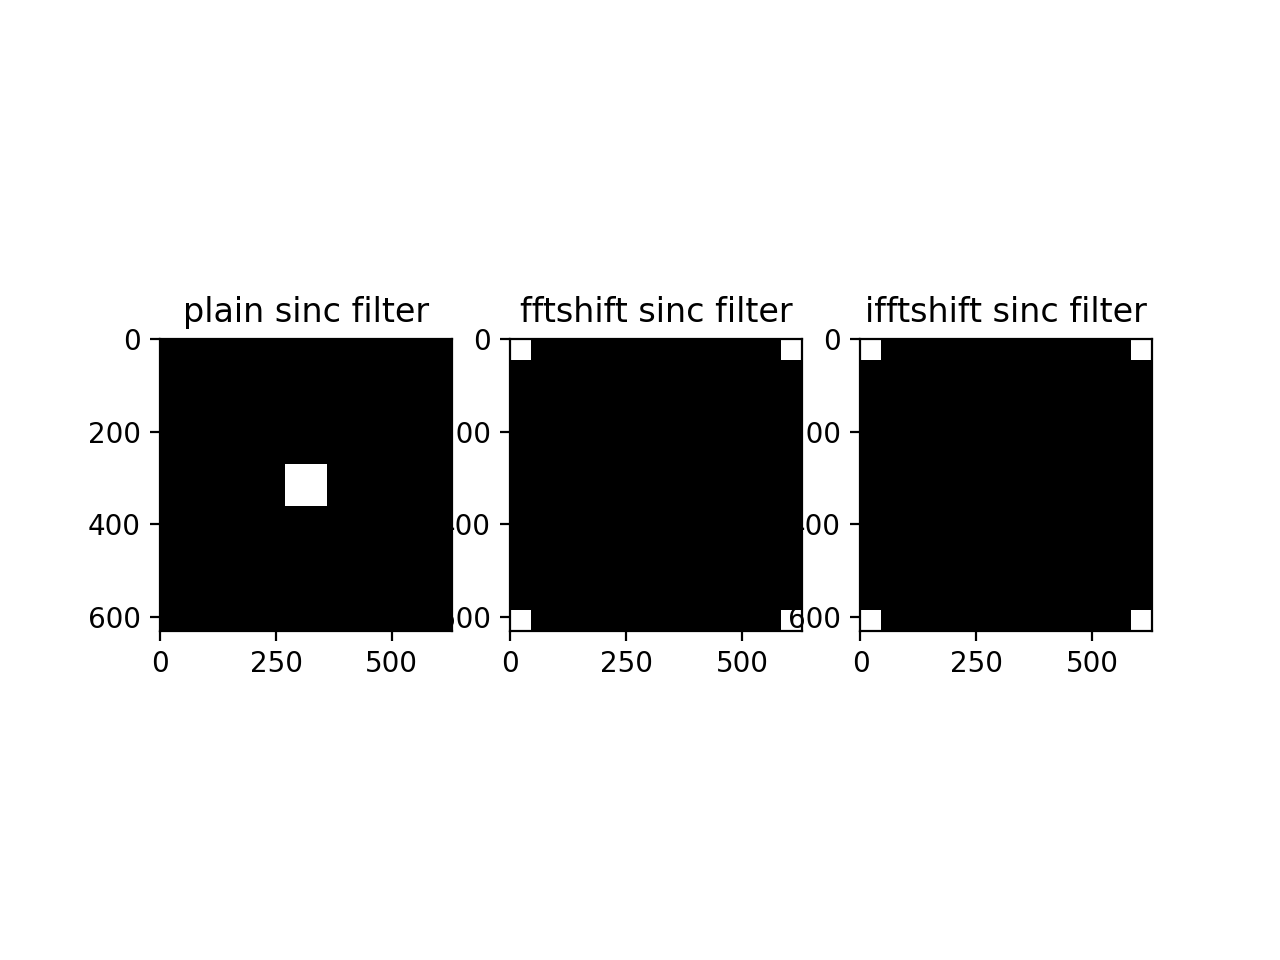

Text(0.5, 1.0, 'ifftshift sinc filter')

In [42]:
plt.figure()
plt.subplot(131)
plt.imshow(sinc_filter)
plt.title('plain sinc filter')
plt.subplot(132)
plt.imshow(sinc_filter2)
plt.title('fftshift sinc filter')
plt.subplot(133)
plt.imshow(sinc_filter3)
plt.title('ifftshift sinc filter')



* Apply the filter to the image. Remember the convolution theorem! Consider that `sinc_filter` is already the FFT of the Kernel. Discard the imaginary part of the result.

In [43]:
img_sinc = np.fft.ifft2(img_fft * sinc_filter2).real

<IPython.core.display.Javascript object>


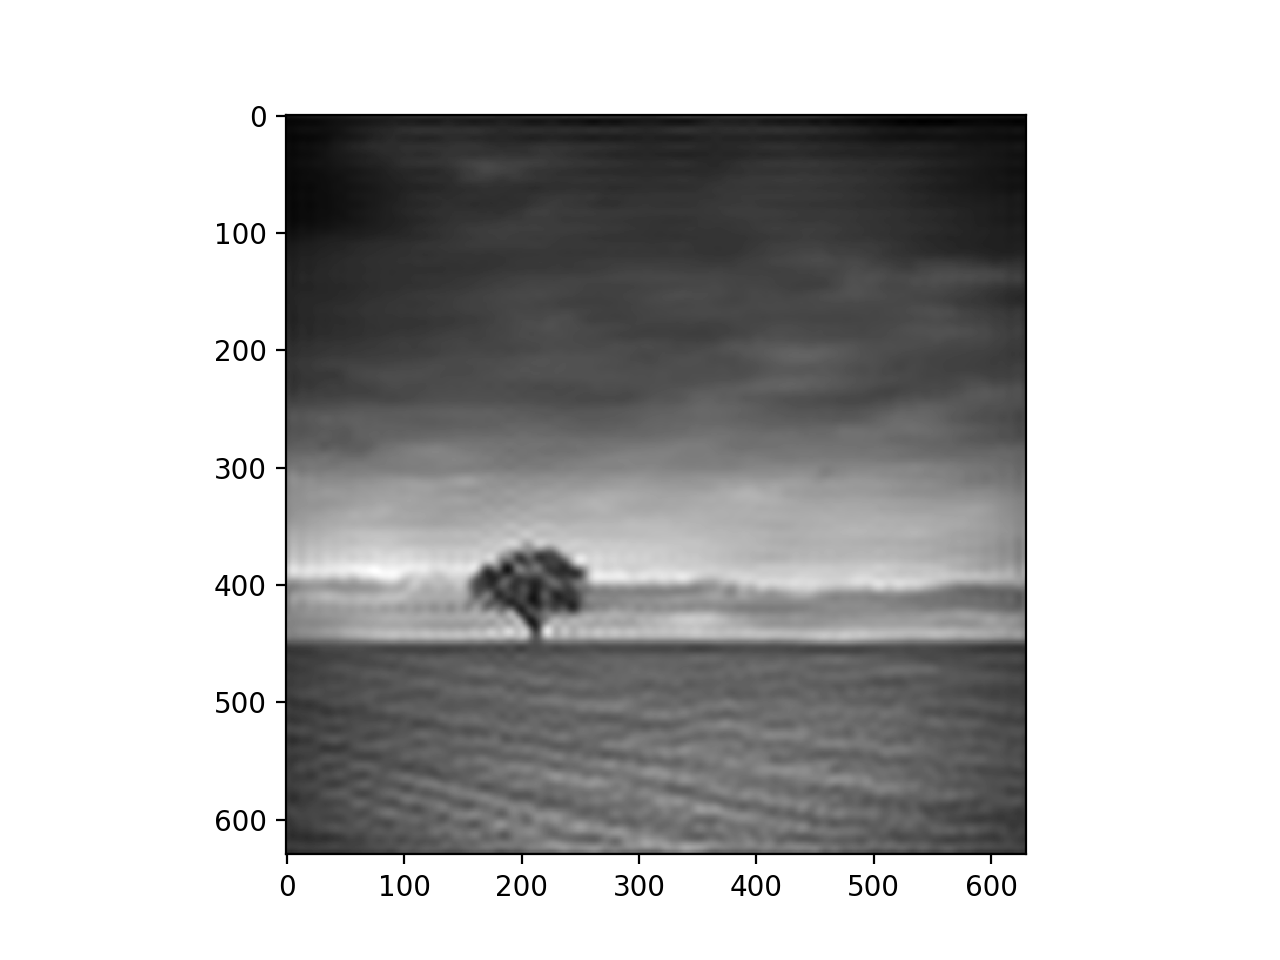

In [44]:
plt.figure()
plt.imshow(img_sinc)

<IPython.core.display.Javascript object>


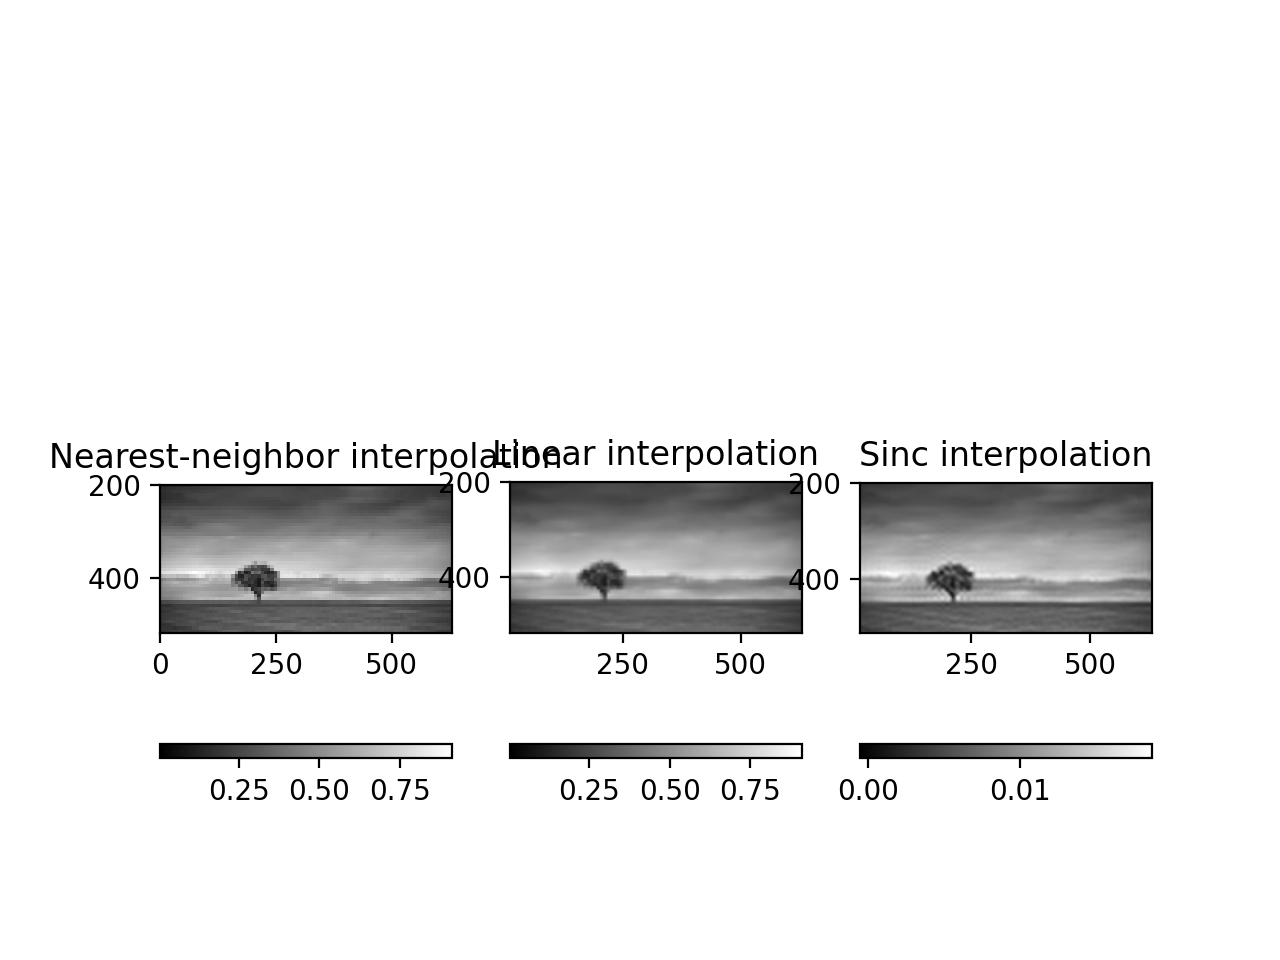

In [45]:
plt.figure()
plt.subplot(131); plt.title('Nearest-neighbor interpolation')
plt.imshow(img_nearest); plt.colorbar(orientation='horizontal')
plt.subplot(132); plt.title('Linear interpolation')
plt.imshow(img_linear); plt.colorbar(orientation='horizontal')
plt.subplot(133); plt.title('Sinc interpolation')
plt.imshow(img_sinc); plt.colorbar(orientation='horizontal')